In [60]:
#common imports
import numpy as np
import matplotlib.pyplot as plt
from random import choice

#keras imports
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, RandomFlip, RandomRotation, Rescaling
from keras.regularizers import l1, l2,l1_l2
from keras.backend import clear_session
from os import path, getcwd, listdir, remove, makedirs, walk
from keras.utils import image_dataset_from_directory
from tensorflow.data import AUTOTUNE
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from keras.callbacks import ModelCheckpoint
import pandas as pd
from shutil import copyfile
import ipyparams
import ipynbname

#Hyperparameters
OPTIMIZER = Adam
LOSS_FUNCTION = BinaryCrossentropy
METRICS = [BinaryAccuracy(name='accuracy')]
EPOCHS = 25
BATCH_SIZE = 32
VERBOSE = 2
REGULARIZER=None
NUMBER_OF_CLASSES = 2

#variables
drive_dir_colab = '/content/drive/MyDrive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification'

drive_dir_mac = '/Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification'
currentNotebook = ipyparams.notebook_name
DATASET_NAMES = ('train','valid','test')
CLASS_DIRECTORY_NAMES = ('class_fracture','class_no_fracture')
DATASET_DIRECTORY = drive_dir_mac
TOP_DIRECTORY_CLASSIFIFICATIONS = path.join(DATASET_DIRECTORY ,'categorised_images')
jupyter_dir = getcwd()
#notebook attributes
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

#to run locally on mac see : https://github.com/tensorflow/tensorflow/issues/33285
#'/Users/chris/PycharmProjects/Tensorflow/.venv/lib/python3.11/site-packages/tensorflow/python/keras/utils/data_utils.py'

<IPython.core.display.Javascript object>

In [62]:
import ipynbname


nb_fname='simple CNN'
nb_path=PosixPath('/Users/chris/PycharmProjects/Fractect/simple CNN.ipynb')


In [42]:
def categorise_images(a_dataset_name):
    fracture_directory = TOP_DIRECTORY_CLASSIFIFICATIONS + '/' + a_dataset_name + '/' + CLASS_DIRECTORY_NAMES[0]
    no_fracture_directory = TOP_DIRECTORY_CLASSIFIFICATIONS + '/' + a_dataset_name + '/' + CLASS_DIRECTORY_NAMES[-1]

    if path.exists(fracture_directory) == False:  
        makedirs(fracture_directory) 
    if path.exists(no_fracture_directory) == False:  
        makedirs(no_fracture_directory) 

    #read labels into pandas df
    a_labels_filepath = a_dataset_name + '/labels/labels.csv'
    csv_filepath = path.join(DATASET_DIRECTORY, a_labels_filepath)
    df = pd.read_csv(path.join(DATASET_DIRECTORY, csv_filepath))
    df = df.set_index('filename')

    #walk through files and copy file to relevant directory
    images_dir = DATASET_DIRECTORY + a_dataset_name + '/images/'
    filenames = []
    for (dirpath, dirnames, filenames) in walk(images_dir):
        filenames.extend(filenames)
 
    for filename in filenames:
        #ignore mac os system file
        if filename.endswith('.DS_Store'):
            pass
        elif df.loc[filename]['target'] == 1:
            destination = fracture_directory + '/' + filename
        else:
            destination = no_fracture_directory + '/' + filename
        source = images_dir + filename
        copyfile(source, destination)

In [43]:
for dataset_name in DATASET_NAMES:
    categorise_images(dataset_name)

In [44]:
def load_images(dataset_name):
    
    return image_dataset_from_directory(
    directory=path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, dataset_name),
    labels='inferred',
    label_mode="binary",
    color_mode="grayscale",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False
)

In [45]:
def check_for_corrupted_images(a_folder_path):
    from pathlib import Path
    import imghdr

    image_extensions = [".png", ".jpg"]  # add there all your images file extensions

    img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
    for filepath in Path(a_folder_path).rglob("*"):
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [46]:
def find_and_remove_non_jpg_files(a_folder_path):
    num_skipped = 0
    for fname in listdir(a_folder_path):
        fpath = path.join(a_folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            print('removing non-image file: ' + fpath)
            remove(fpath)

    print(f"Deleted {num_skipped} files.")

In [48]:
folders_checked = 0
for dataset_name in DATASET_NAMES:
    for class_dir_name in CLASS_DIRECTORY_NAMES:
        folder_path = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, dataset_name,class_dir_name)
        print('checking folder: '+folder_path)
        find_and_remove_non_jpg_files(folder_path)
        folders_checked +=1
print('checked', folders_checked, 'folders')

checking folder: /Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification/categorised_images/train/class_fracture
Deleted 0 files.
checking folder: /Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification/categorised_images/train/class_no_fracture
Deleted 0 files.
checking folder: /Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent University/MSc/Modules/COMP8260_AI_Systems_Implementation/Project/datasets/binary_classification/categorised_images/valid/class_fracture
Deleted 0 files.
checking folder: /Users/chris/Library/CloudStorage/GoogleDrive-cjameswalmsley@gmail.com/My Drive/Shared with Julia/Education/Kent University/MSc/

In [49]:
train_ds= load_images('train')
test_ds = load_images('test')
valid_ds = load_images('valid')

Found 3658 files belonging to 2 classes.
Found 169 files belonging to 2 classes.
Found 348 files belonging to 2 classes.


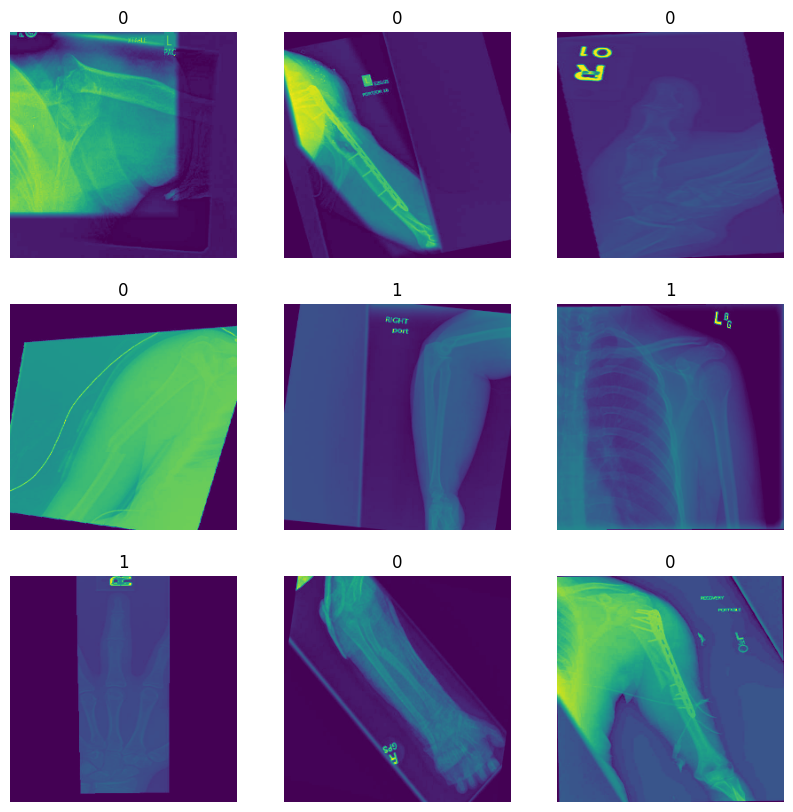

In [50]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [51]:
data_augmentation_layers = [
    RandomFlip("horizontal"),
    RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

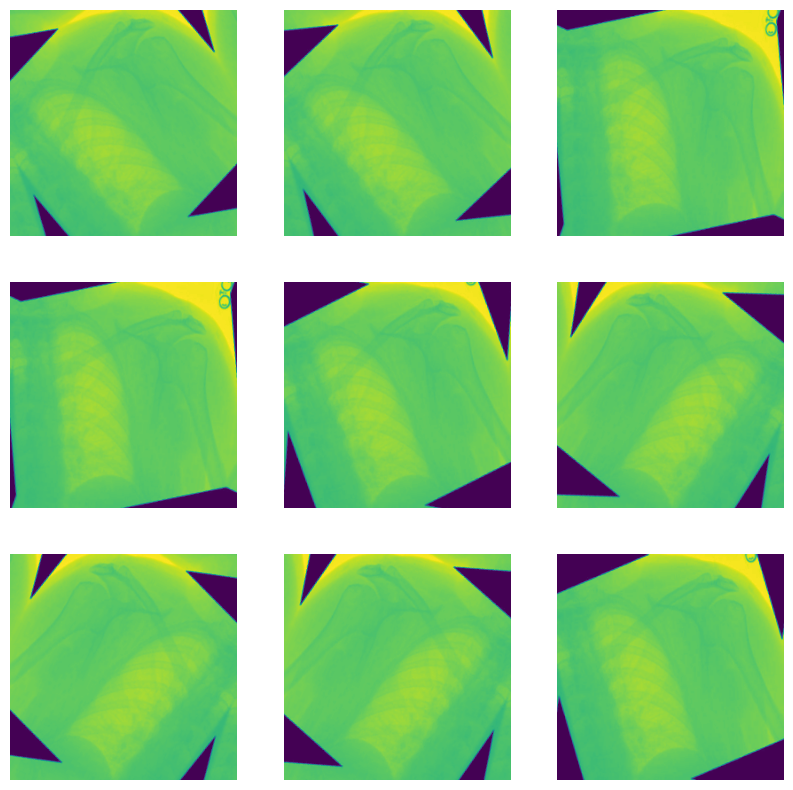

In [52]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [53]:
#augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(lambda img, label: (data_augmentation(img), label),num_parallel_calls=AUTOTUNE,)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(AUTOTUNE)
valid_ds = valid_ds.prefetch(AUTOTUNE)

In [54]:
def create_model():
#create a Sequential  model
    model = models.Sequential()
    input_shape = (256,256,1)

#Add the layers
    model.add(Input(input_shape))
    model.add(Rescaling(1.0 / 255))
    #Add 2 convolutional layers paired with max pooling layers
    model.add(Conv2D(filters = 64, kernel_regularizer=REGULARIZER, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 128, kernel_regularizer=REGULARIZER, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
   
#Flatten the output so that it can be processed as a Vector by the subsequnet Dense layer
    model.add(Flatten())

#add a fully connected layer with  64 neurons and a relu activation function ouput shape = 64
    model.add(Dense(64, kernel_regularizer=REGULARIZER, activation='relu'))
    #add
    model.add(Dense(1, kernel_regularizer=REGULARIZER, activation='sigmoid'))

    return model

In [55]:
model = create_model()
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │    31,490,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,564,673 (120.41 MB)

 Trainable params: 31,564,673 (120.41 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model.compile(optimizer=OPTIMIZER(),loss=LOSS_FUNCTION(),metrics=METRICS)

In [57]:
callbacks = [ModelCheckpoint("/nb_fname/save_at_{epoch}.keras"),]

model_history = model.fit(
                        train_ds,
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        validation_data=valid_ds
                        )

clear_session

Epoch 1/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 24s 183ms/step - accuracy: 0.5094 - loss: 0.8292 - val_accuracy: 0.4598 - val_loss: 0.6924
Epoch 2/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.5516 - loss: 0.6813 - val_accuracy: 0.4856 - val_loss: 0.7086
Epoch 3/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - accuracy: 0.5466 - loss: 0.6791 - val_accuracy: 0.4483 - val_loss: 0.7306
Epoch 4/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - accuracy: 0.5611 - loss: 0.6747 - val_accuracy: 0.4741 - val_loss: 0.7183
Epoch 5/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.5641 - loss: 0.6719 - val_accuracy: 0.5546 - val_loss: 0.7218
Epoch 6/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.5648 - loss: 0.6709 - val_accuracy: 0.4828 - val_loss: 0.7355
Epoch 7/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.5620 - loss: 0.6723 - val_accuracy: 0.5345 - val_loss: 0.7352
Epoch 8/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.5769 - loss: 0

In [58]:
evaluation = model.evaluate(train_ds)

115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7312 - loss: 0.5282


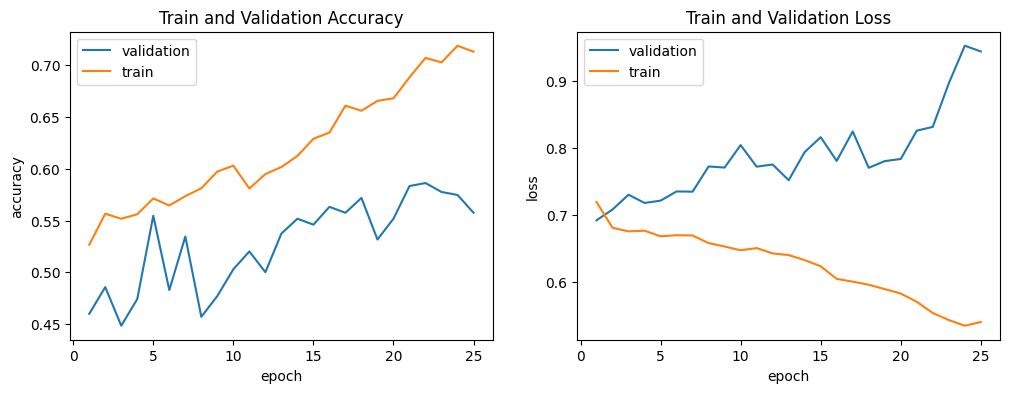

In [59]:
train_accuracy = model_history.history['accuracy']
valid_accuracy = model_history.history['val_accuracy']
train_loss = model_history.history['loss']
valid_loss = model_history.history['val_loss']

fig, (accuracy, loss) = plt.subplots(1, 2, sharex=True, sharey=False)
fig.set_size_inches(12,4 )
accuracy.plot(range(1, EPOCHS+1), valid_accuracy) 
accuracy.plot(range(1, EPOCHS+1), train_accuracy)  
accuracy.set_ylabel('accuracy')
accuracy.set_xlabel('epoch')
accuracy.legend(['validation','train'], loc='upper left')
accuracy.set_title('Train and Validation Accuracy')

loss.plot(range(1, EPOCHS+1), valid_loss)
loss.plot(range(1, EPOCHS+1), train_loss)
loss.set_ylabel('loss')
loss.set_xlabel('epoch')
loss.legend(['validation', 'train'], loc='upper left')
loss.set_title('Train and Validation Loss')

plt.show()